In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset, random_split

from torchvision import datasets, models, utils, transforms
from torchvision import transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2


from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device('cuda')

In [3]:
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')

## 전체 dataset 분포 그리기

In [30]:
import os
path_dir = '../all_data'
file_list = os.listdir(path_dir)
print(file_list)
count_label = {}
for label in file_list:
    sub_label = path_dir+'/'+label
    sub_file_list = os.listdir(sub_label)
    count_label[label] = len(sub_file_list)

['test', 'train', 'validation']


In [31]:
count_label

{'test': 5, 'train': 5, 'validation': 5}

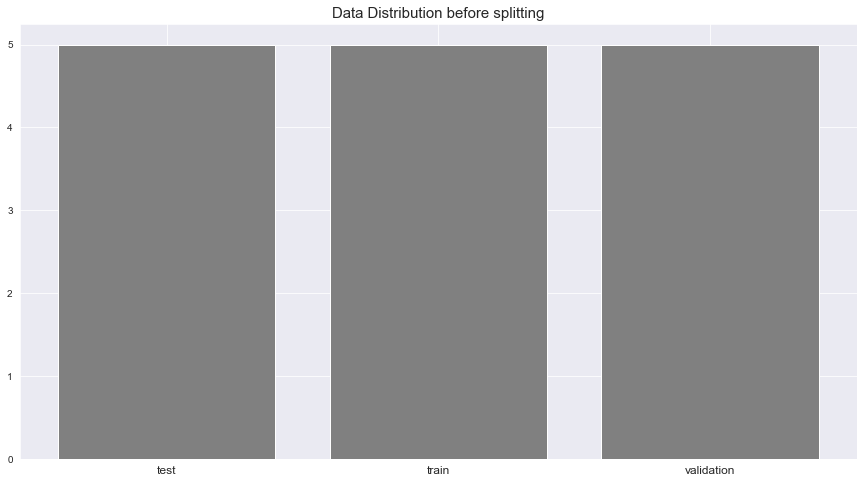

In [32]:
plt.rc('xtick', labelsize = 12)
x = count_label.keys()
y = count_label.values()
plt.figure(figsize = (15,8))
plt.title('Data Distribution before splitting', fontsize = 15)
plt.bar(x,y, color = 'gray')
plt.savefig('Data Distribution before splitting.png')

In [33]:
path_dir+'/'+'4_Carcinoma'

'../all_data/4_Carcinoma'

In [74]:
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps    

#다음 변수를 수정하여 새로 만들 이미지 갯수를 정합니다.
num_augmented_images = 150

for label in file_list[1:]: #Normal 제외하고 
    file_path = path_dir+'/'+label
    save_path = path_dir+'/'+label+'/'
    file_names = os.listdir(file_path)
    total_origin_image_num = len(file_names)
    print(total_origin_image_num)
    augment_cnt = 1

    for i in range(1, num_augmented_images):
        change_picture_index = random.randrange(1, total_origin_image_num-1)
        #print(change_picture_index)
        #print(file_names[change_picture_index])
        file_name = file_names[change_picture_index]
    
        origin_image_path = file_path+'/' + file_name
        #print(origin_image_path)
        image = Image.open(origin_image_path)
        random_augment = random.randrange(1,3)
    
        if(random_augment == 1):
            #이미지 좌우 반전
            #print("invert")
            inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT)
            inverted_image.save(save_path + 'inverted_' + str(augment_cnt) + '.png')
    
        else:
            #이미지 기울이기
            #print("rotate")
            rotated_image = image.rotate(random.randrange(-20, 20))
            rotated_image.save(save_path + 'rotated_' + str(augment_cnt) + '.png')
        
        
        augment_cnt += 1
        file_names = os.listdir(file_path)
        current_num = len(file_names)
        if current_num == 200:
            print('200개 달성! 다음 label로  이동')
            break

107
200개 달성! 다음 label로  이동
113
200개 달성! 다음 label로  이동
104
200개 달성! 다음 label로  이동
91
200개 달성! 다음 label로  이동


In [34]:
import os
path_dir = '../all_data'
file_list = os.listdir(path_dir)
print(file_list)
count_label = {}
for label in file_list:
    sub_label = path_dir+'/'+label
    sub_file_list = os.listdir(sub_label)
    count_label[label] = len(sub_file_list)
count_label

['test', 'train', 'validation']


{'test': 5, 'train': 5, 'validation': 5}

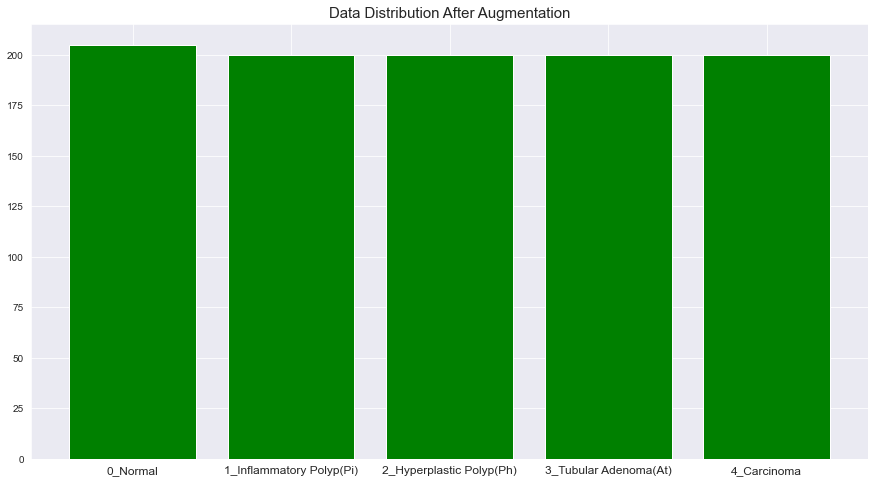

In [76]:
plt.rc('xtick', labelsize = 12)
x = count_label.keys()
y = count_label.values()
plt.figure(figsize = (15,8))
plt.title('Data Distribution After Augmentation', fontsize = 15)
plt.bar(x,y, color = 'green')
plt.savefig('Data Distribution After Augmentation.png')

## Train Validation Test Split

In [21]:
from torch.utils.data.sampler import SubsetRandomSampler

In [35]:
path = '../all_data'
data_transforms = {
    "train": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    "validation": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    "test": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
}


In [36]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [37]:
train_loader = DataLoader(dataset=image_datasets['train'], shuffle=False, batch_size=8)
val_loader = DataLoader(dataset=image_datasets['train'], shuffle=False, batch_size=1)
test_loader = DataLoader(dataset=image_datasets['test'], shuffle=False, batch_size=1)

Output label tensors:  tensor([0, 0, 0, 0, 0, 0, 0, 0])

Output label tensor shape:  torch.Size([8])


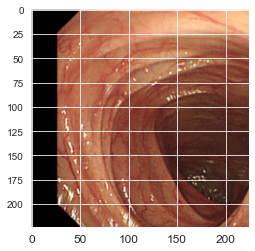

In [38]:
single_batch = next(iter(train_loader))
single_batch[0].shape
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape
plt.imshow(single_image.permute(1, 2, 0))

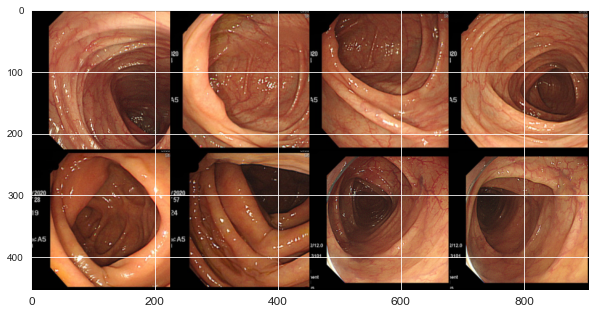

In [39]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [40]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [41]:
model = resnet18
model.to(device)
#print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [42]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [43]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [44]:
print("Begin training.")
for e in tqdm(range(1, 101)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 7.73932 | Val Loss: 0.02452 | Train Acc: 38.563| Val Acc: 100.000
Epoch 02: | Train Loss: 5.15845 | Val Loss: 0.04226 | Train Acc: 19.549| Val Acc: 100.000
Epoch 03: | Train Loss: 3.26074 | Val Loss: 0.26093 | Train Acc: 12.113| Val Acc: 100.000
Epoch 04: | Train Loss: 2.97700 | Val Loss: 0.40222 | Train Acc: 10.324| Val Acc: 100.000
Epoch 05: | Train Loss: 2.53218 | Val Loss: 0.36203 | Train Acc: 6.775| Val Acc: 100.000
Epoch 06: | Train Loss: 2.35673 | Val Loss: 0.71454 | Train Acc: 9.056| Val Acc: 50.000
Epoch 07: | Train Loss: 2.24513 | Val Loss: 0.86686 | Train Acc: 3.620| Val Acc: 50.000
Epoch 08: | Train Loss: 1.98480 | Val Loss: 0.37011 | Train Acc: 9.113| Val Acc: 100.000
Epoch 09: | Train Loss: 2.05269 | Val Loss: 1.14099 | Train Acc: 5.169| Val Acc: 50.000
Epoch 10: | Train Loss: 1.98201 | Val Loss: 0.79622 | Train Acc: 2.268| Val Acc: 100.000
Epoch 11: | Train Loss: 1.91338 | Val Loss: 0.97677 | Train Acc: 6.648| Val Acc: 100.000
Epoch 12: | Train Lo

Epoch 94: | Train Loss: 1.62470 | Val Loss: 1.57476 | Train Acc: 6.254| Val Acc: 50.000
Epoch 95: | Train Loss: 1.61783 | Val Loss: 1.57982 | Train Acc: 6.958| Val Acc: 50.000
Epoch 96: | Train Loss: 1.61373 | Val Loss: 1.58119 | Train Acc: 9.268| Val Acc: 50.000
Epoch 97: | Train Loss: 1.60186 | Val Loss: 1.47108 | Train Acc: 12.225| Val Acc: 50.000
Epoch 98: | Train Loss: 1.65633 | Val Loss: 1.66746 | Train Acc: 8.014| Val Acc: 50.000
Epoch 99: | Train Loss: 1.62835 | Val Loss: 1.55461 | Train Acc: 9.620| Val Acc: 50.000
Epoch 100: | Train Loss: 1.61825 | Val Loss: 1.56115 | Train Acc: 12.225| Val Acc: 50.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

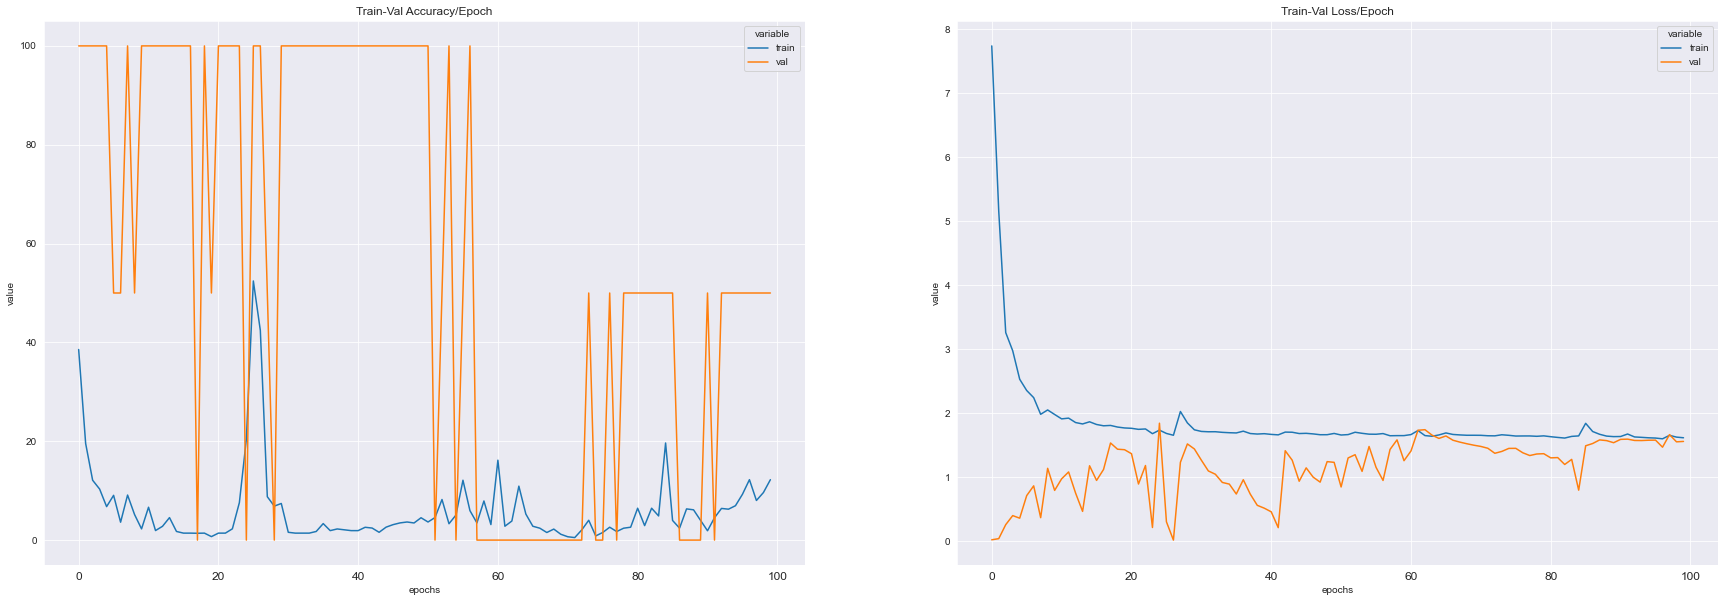

In [45]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [46]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/302 [00:00<?, ?it/s]

In [47]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.33      0.02      0.03        62
           1       0.43      0.05      0.09        60
           2       0.25      0.13      0.17        60
           3       0.37      0.18      0.24        60
           4       0.23      0.87      0.36        60

    accuracy                           0.25       302
   macro avg       0.32      0.25      0.18       302
weighted avg       0.32      0.25      0.18       302



In [48]:
print(confusion_matrix(y_true_list, y_pred_list))

[[ 1  0  8  1 52]
 [ 0  3  6  8 43]
 [ 0  1  8  7 44]
 [ 0  2  8 11 39]
 [ 2  1  2  3 52]]


In [49]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

NameError: name 'idx2class' is not defined